Файл Voronezh_region.geojson успешно загружен с https://raw.githubusercontent.com/Dimatron74/foliumVRN/refs/heads/main/json/Voronezh_region.geojson
Файл combined_table.csv уже существует. Загрузка не требуется.
Получение данных о населённых пунктах с OpenStreetMap...
Данные о населённых пунктах с OpenStreetMap успешно получены
Добавление населённых пунктов на карту...
Данные о населённых пунктах успешно добавлены на карту
Карта успешно сохранена в файл: map.html



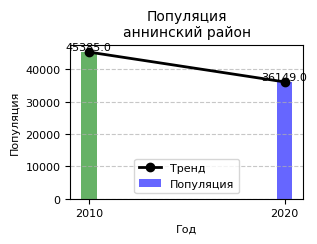
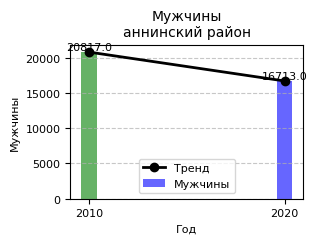
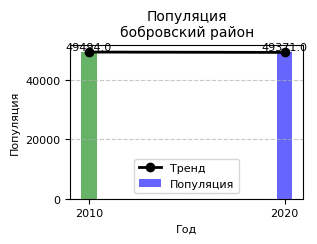
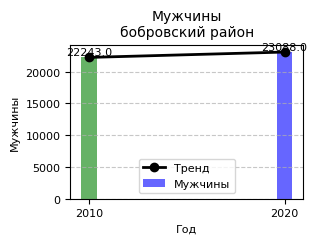
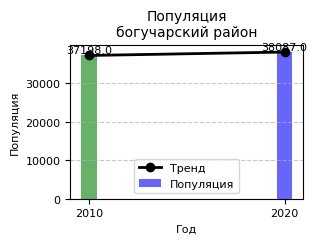
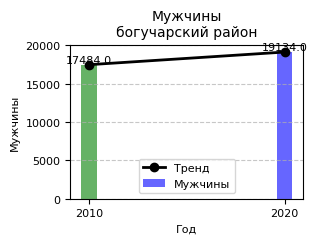
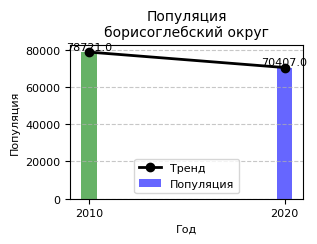
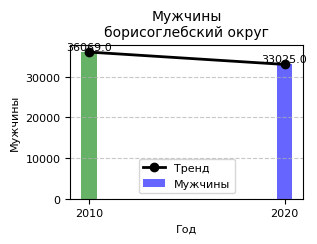
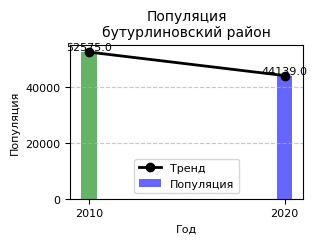
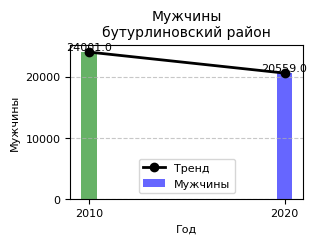
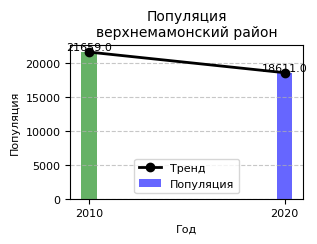
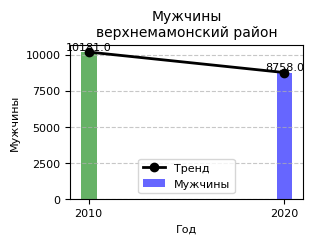
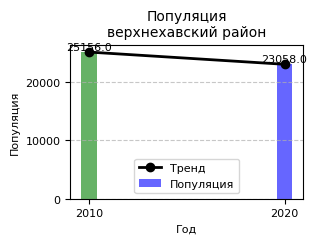
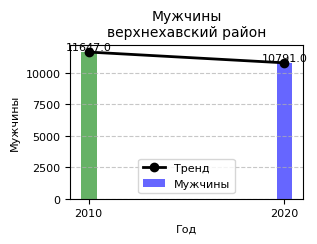
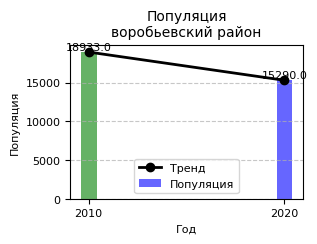
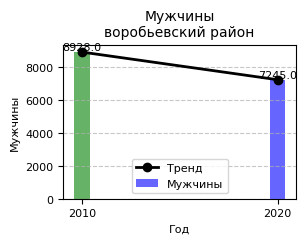
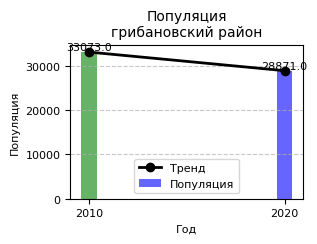
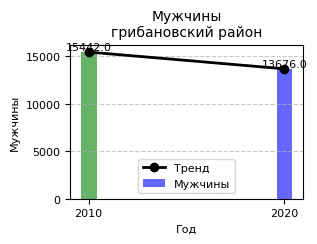
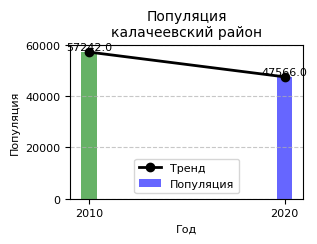
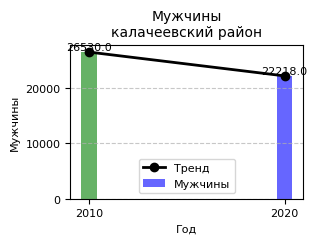
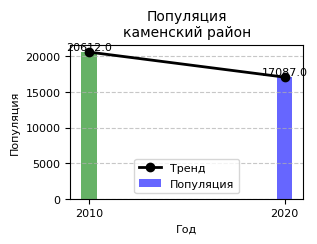
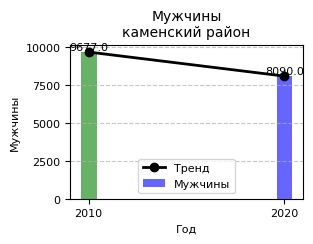
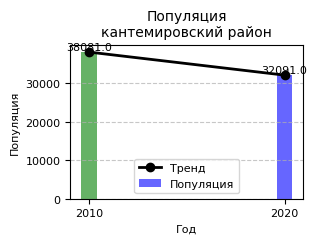
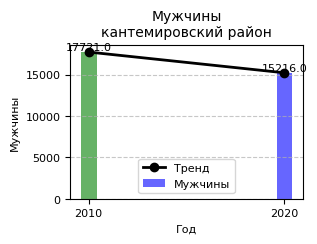
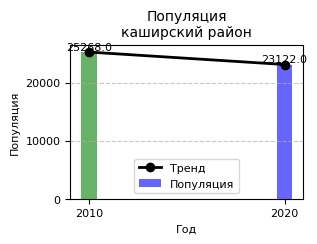
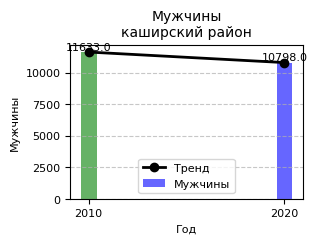
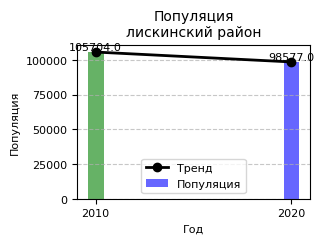
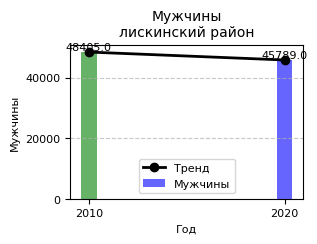
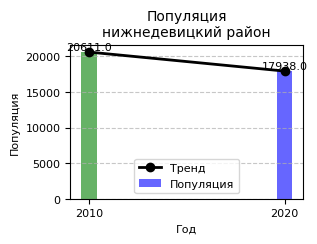
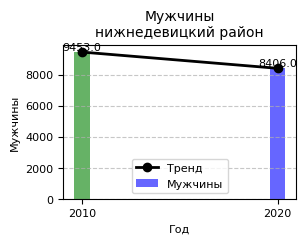
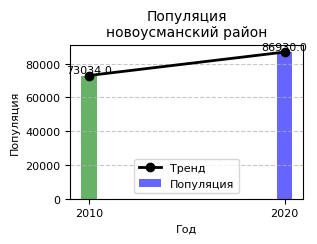
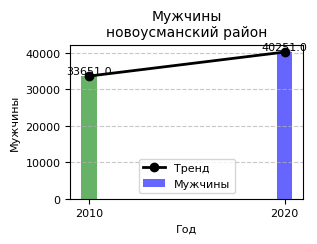
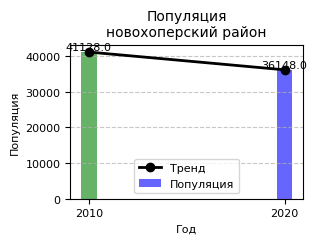
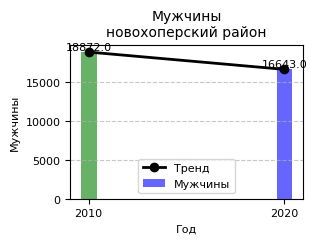
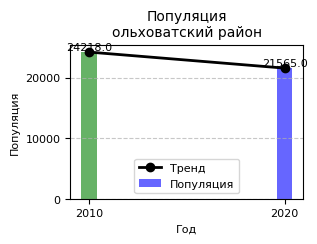
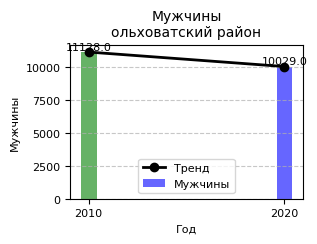
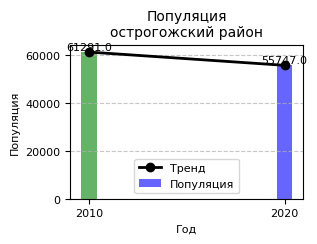
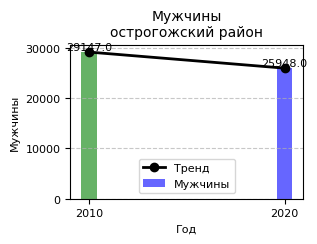
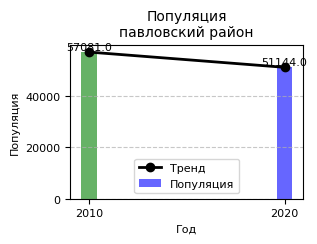
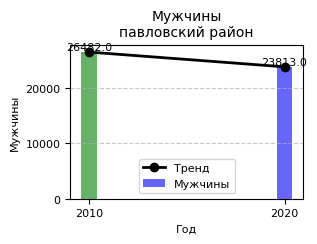
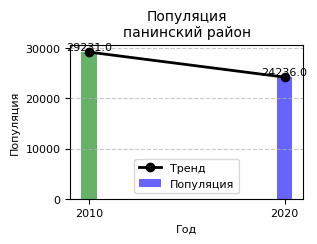
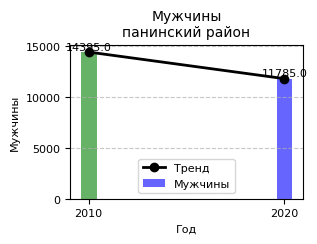
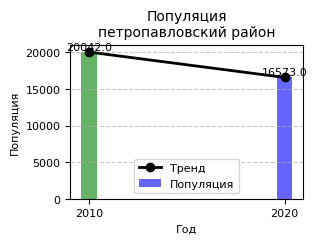
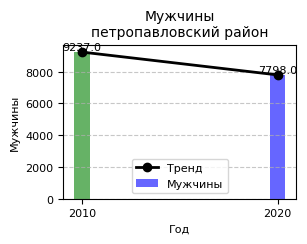
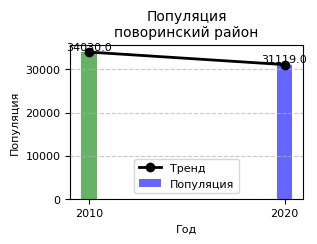
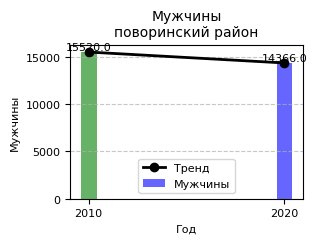
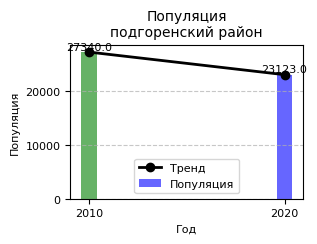
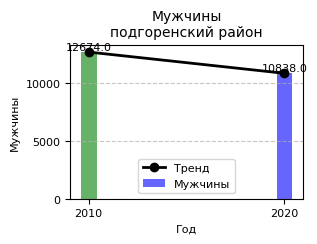
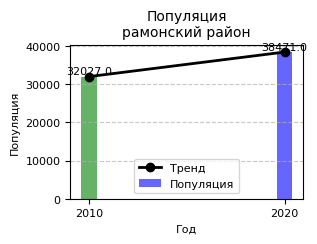
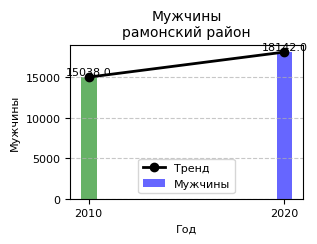
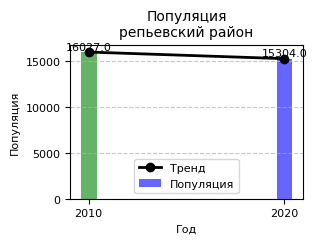
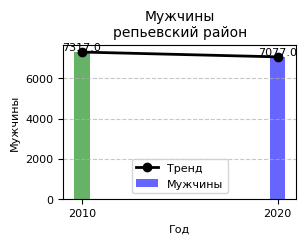
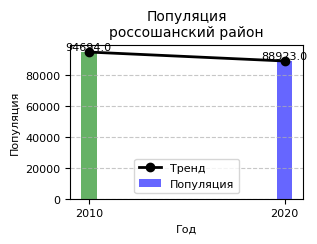
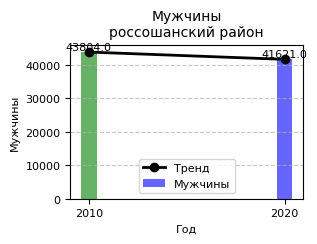
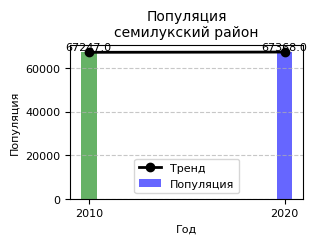
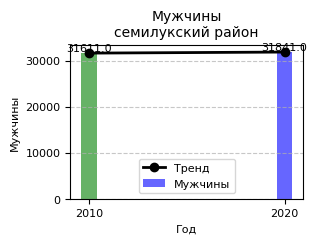
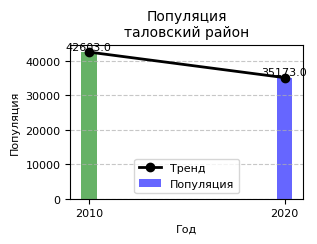
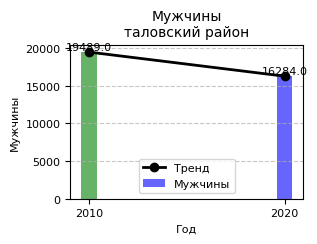
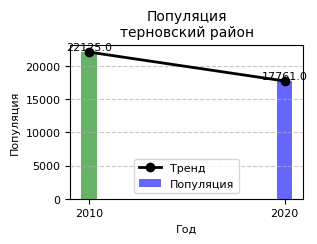
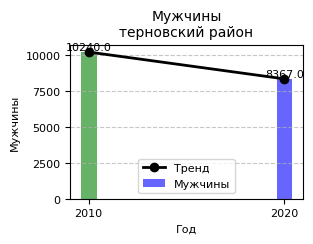
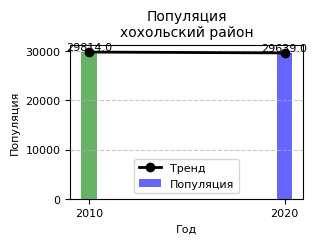
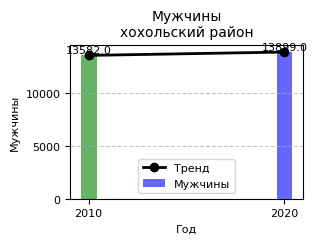
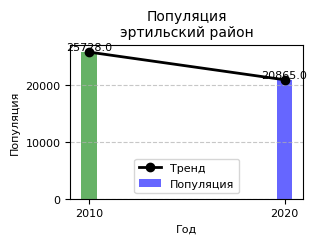
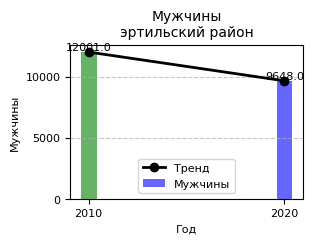
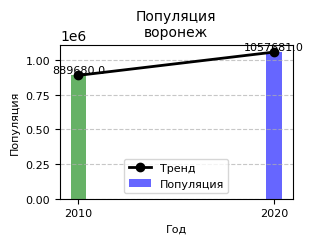
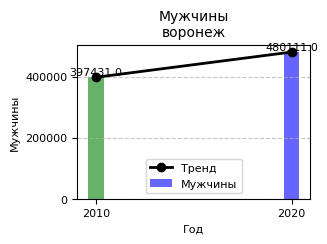
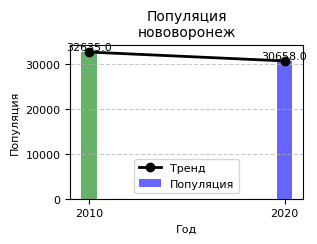
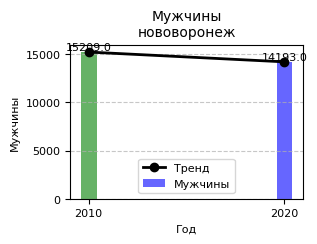

In [1]:
import pandas as pd
import folium
import json
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from rapidfuzz import fuzz, process
from datetime import datetime 
from functools import lru_cache
import requests
import subprocess
import os

# Словарь для хранения важных рабочих английских названий столбцов
# Теперь суффиксы не используются, имена столбцов должны быть такими же, как в CSV
column_names = {
    "region": "region",
    "year": "year",
    "total_population": "total_population"
}

# Функция для обработки выбора пользователя и загрузки файлов
def load_data_files():
    """Обрабатывает выбор пользователя для загрузки GeoJSON и CSV файлов с максимальной гибкостью.
    
    Returns:
        tuple: Путь к GeoJSON и CSV файлам (могут быть дефолтными, пользовательскими или существующими).
    """
    import os
    import requests
    
    default_geojson_path = 'Voronezh_region.geojson'
    default_csv_path = 'combined_table.csv'
    custom_folder = 'custom_files'  # Папка для пользовательских файлов

    # Стандартные ссылки GitHub
    default_geojson_url = 'https://raw.githubusercontent.com/Dimatron74/foliumVRN/refs/heads/main/json/Voronezh_region.geojson'
    default_csv_url = 'https://raw.githubusercontent.com/Dimatron74/foliumVRN/refs/heads/main/combined_table.csv'
    
    # Создаём папку для пользовательских файлов, если её нет
    if not os.path.exists(custom_folder):
        os.makedirs(custom_folder)

    # Инициализируем возвращаемые пути
    final_geojson_path = default_geojson_path
    final_csv_path = default_csv_path

    # Функция для загрузки файла (замена download_file)
    def download_from_url(file_path, url):
        if not os.path.exists(file_path):
            response = requests.get(url)
            if response.status_code == 200:
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                print(f"Файл {file_path} успешно загружен с {url}")
            else:
                print(f"Ошибка при загрузке {file_path}: HTTP {response.status_code}")
        else:
            print(f"Файл {file_path} уже существует. Загрузка не требуется.")

    # Спрашиваем пользователя о способе загрузки данных
    source_choice = input("Хотите загрузить данные с GitHub (1) или использовать локальные файлы (2)? Введите 1 или 2: ").strip()
    
    if source_choice == '1':
        # Вариант с GitHub
        github_choice = input("Использовать стандартные ссылки GitHub (1) или ввести свои URL (2)? Введите 1 или 2: ").strip()
        
        if github_choice == '1':
            # Стандартные ссылки GitHub
            download_from_url(default_geojson_path, default_geojson_url)
            download_from_url(default_csv_path, default_csv_url)
            return default_geojson_path, default_csv_path
        
        elif github_choice == '2':
            # Пользовательские URL с гибкостью выбора
            print('Оставьте поле пустым, если не хотите загружать новый файл с GitHub для этого типа данных.')
            
            geojson_url = input("Введите URL для GeoJSON файла с GitHub (или оставьте пустым): ").strip()
            csv_url = input("Введите URL для CSV файла с GitHub (или оставьте пустым): ").strip()
            
            # Обработка GeoJSON
            if geojson_url:
                custom_geojson_path = os.path.join(custom_folder, 'custom_Voronezh_region.geojson')
                download_from_url(custom_geojson_path, geojson_url)
                final_geojson_path = custom_geojson_path
            else:
                # Если URL не указан, проверяем наличие локального файла или загружаем стандартный
                if not os.path.exists(default_geojson_path):
                    download_from_url(default_geojson_path, default_geojson_url)
                final_geojson_path = default_geojson_path
            
            # Обработка CSV
            if csv_url:
                custom_csv_path = os.path.join(custom_folder, 'custom_combined_table.csv')
                download_from_url(custom_csv_path, csv_url)
                final_csv_path = custom_csv_path
            else:
                # Если URL не указан, проверяем наличие локального файла или загружаем стандартный
                if not os.path.exists(default_csv_path):
                    download_from_url(default_csv_path, default_csv_url)
                final_csv_path = default_csv_path
            
            return final_geojson_path, final_csv_path
        
        else:
            print("Неверный выбор. Используются локальные файлы по умолчанию или загружаются стандартные с GitHub, если их нет.")
            if not os.path.exists(default_geojson_path):
                download_from_url(default_geojson_path, default_geojson_url)
            if not os.path.exists(default_csv_path):
                download_from_url(default_csv_path, default_csv_url)
            return default_geojson_path, default_csv_path
    
    elif source_choice == '2':
        # Вариант с локальными файлами
        geojson_input = input(f"Введите путь к локальному GeoJSON файлу (или оставьте пустым для '{default_geojson_path}'): ").strip()
        csv_input = input(f"Введите путь к локальному CSV файлу (или оставьте пустым для '{default_csv_path}'): ").strip()
        
        # Если пользователь указал путь, используем его, иначе дефолтный
        final_geojson_path = geojson_input if geojson_input else default_geojson_path
        final_csv_path = csv_input if csv_input else default_csv_path
        
        # Проверяем наличие файлов, если они отсутствуют — предупреждаем
        if not os.path.exists(final_geojson_path):
            print(f"Файл {final_geojson_path} не найден. Попробуйте загрузить его с GitHub или указать корректный путь.")
        if not os.path.exists(final_csv_path):
            print(f"Файл {final_csv_path} не найден. Попробуйте загрузить его с GitHub или указать корректный путь.")
        
        return final_geojson_path, final_csv_path
    
    else:
        print("Неверный выбор. Используются локальные файлы по умолчанию или загружаются стандартные с GitHub, если их нет.")
        if not os.path.exists(default_geojson_path):
            download_from_url(default_geojson_path, default_geojson_url)
        if not os.path.exists(default_csv_path):
            download_from_url(default_csv_path, default_csv_url)
        return default_geojson_path, default_csv_path

# Загружаем файлы на основе выбора пользователя
geojson_path, csv_path = load_data_files()

# Загружаем данные с двумя строками заголовков
combined_data_df = pd.read_csv(csv_path, sep=';', encoding='utf-8-sig', header=[0, 1])

# Разделяем заголовки на английские и русские
english_headers = combined_data_df.columns.get_level_values(0).str.lower()  # Все английские названия в нижний регистр
russian_headers = combined_data_df.columns.get_level_values(1)

# Создаем словарь маппинга между английскими и русскими названиями
header_mapping = dict(zip(english_headers, russian_headers))

# Переименовываем столбцы на английские названия
combined_data_df.columns = english_headers

# Приводим данные к нижнему регистру и нормализуем
combined_data_df[column_names["region"]] = combined_data_df[column_names["region"]].str.strip().str.lower().str.replace('ё', 'е')

# Загрузка GeoJSON данных
with open(geojson_path, 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Центр карты (потом автоматизировать)
region_center_incsv = [51.67, 39.18]  # Указать центр области
m = folium.Map(location=region_center_incsv, zoom_start=8)

# Функция для получения русского названия
def get_russian_name(english_name):
    """Возвращает русское название столбца по его английскому имени."""
    return header_mapping.get(english_name, english_name)

# Функция для группировки столбцов по годам для конкретного региона
def group_columns_by_year(df, region_name):
    """Группирует данные по годам для заданного региона, возвращает словарь с данными по годам для каждого столбца.
    
    Args:
        df (pd.DataFrame): DataFrame с данными.
        region_name (str): Название региона.
    
    Returns:
        dict: Словарь вида {столбец: {год: значение}}.
    """
    region_data = df[df[column_names["region"]] == region_name]
    grouped_data = {}
    
    # Исключаем служебные столбцы 'region' и 'year'
    data_columns = [col for col in df.columns if col not in [column_names["region"], column_names["year"]]]
    
    for col in data_columns:
        grouped_data[col] = {}
        for _, row in region_data.iterrows():
            year = row[column_names["year"]]
            value = row[col]
            grouped_data[col][year] = value
    
    return grouped_data

# Функция для получения значения ближайшего года
def get_closest_year_value(grouped_data, column, current_year):
    """Возвращает значение столбца для года, ближайшего к заданному.
    
    Args:
        grouped_data (dict): Сгруппированные данные по годам.
        column (str): Название столбца.
        current_year (int): Текущий год для поиска ближайшего.
    
    Returns:
        float or None: Значение для ближайшего года или None, если данных нет.
    """
    if column not in grouped_data or not grouped_data[column]:
        return None
    
    years = list(grouped_data[column].keys())
    values = list(grouped_data[column].values())
    
    if not years:
        return None
    
    closest_year = min(years, key=lambda y: abs(int(y) - current_year))
    return float(values[years.index(closest_year)])

# Функция для поиска соответствия между районами
def find_matching_region(target, candidates):
    """Ищет наиболее подходящий регион из списка кандидатов с использованием нечёткого соответствия."""
    target_normalized = target.strip().lower().replace('ё', 'е')
    if target_normalized in candidates:
        return target_normalized
    match = process.extractOne(
        target_normalized,
        candidates,
        scorer=fuzz.token_set_ratio,
        score_cutoff=85
    )
    if match:
        best_match = match[0]
        if any(best_match != candidate and best_match in candidate for candidate in candidates):
            return None
        return best_match
    return None

# Кэшируем результаты обработки данных для каждого района
@lru_cache(maxsize=None)
def process_district_data(district_name):
    """Обрабатывает данные для района, возвращает совпадение, население и HTML с диаграммами."""
    match = find_matching_region(district_name, combined_data_df[column_names["region"]].unique())
    if not match:
        return None, 0, "Данные отсутствуют"

    # Группируем данные по годам
    grouped_data = group_columns_by_year(combined_data_df, match)
    charts = []
    population = 0

    for column in grouped_data:
        chart = create_chart(match, grouped_data, column)
        if chart:
            charts.append(chart)

        # Вычисляем население
        if column == column_names["total_population"]:
            current_year = datetime.now().year
            population = get_closest_year_value(grouped_data, column, current_year) or 0

    chart_html = ' '.join(charts) if charts else "Данные отсутствуют"
    return match, population, chart_html

# Функция стиля для GeoJSON
def style_function(feature):
    """Определяет стиль для каждого района на карте на основе данных."""
    district_name = feature['properties']['district'].lower().replace('ё', 'е')
    match, population, chart_html = process_district_data(district_name)

    if match:
        popup_html = create_popup_html(district_name.capitalize(), chart_html)
        feature['properties']['popup_html'] = popup_html
        if population:
            feature['properties']['population'] = int(population)
            if population < 35000:
                color = 'green'
            elif population < 500000:
                color = 'orange'
            elif population > 500000:
                color = 'red'
            else:
                color = 'grey'
        else:
            feature['properties']['population'] = "Данные отсутствуют"
            color = 'grey'
    else:
        color = 'grey'

    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.4
    }

# Функция для создания единого HTML для всплывающего окна
def create_popup_html(district_name, chart_html):
    """Создаёт HTML для всплывающего окна с названием района и диаграммами."""
    html_template = f"""
    <div style="width: 100%; max-width: 800px; height: auto; margin: 0 auto; border: 1px solid #ddd; border-radius: 8px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); overflow: hidden; font-family: Arial, sans-serif;">
        <div style="padding: 15px; background-color: #f9f9f9; border-bottom: 1px solid #ddd;">
            <h3 style="margin: 0; font-size: 18px; color: #333;">Район: {district_name}</h3>
        </div>
        <div style="padding: 15px; display: flex; flex-direction: column; align-items: center; max-height: 350px; min-width: 300px; overflow-y: auto; background-color: #fff;">
            {chart_html if chart_html else "<p style='color: #888; text-align: center;'>Данные отсутствуют</p>"}
        </div>
    </div>
    """
    return html_template

# Функция для создания диаграммы
def create_chart(region_name, grouped_data, column):
    """Создаёт диаграмму для заданного столбца и региона на основе данных по годам."""
    group_name = get_russian_name(column)
    if group_name == column:
        print(f"Предупреждение: Русское название не найдено для '{column}'. Используется английское название.")

    if column not in grouped_data or not grouped_data[column]:
        return None

    years = [int(year) for year in grouped_data[column].keys()]
    values = [float(value) for value in grouped_data[column].values()]

    if not years or not values:
        return None

    plt.figure(figsize=(3, 2))
    bars = plt.bar(years, values, color=['blue', 'green', 'red'], alpha=0.6, label=group_name)
    plt.plot(years, values, color='black', marker='o', linewidth=2, label='Тренд')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{yval:.1f}", ha='center', va='bottom', fontsize=8)

    plt.title(f'{group_name}\n{region_name}', fontsize=10)
    plt.xlabel('Год', fontsize=8)
    plt.ylabel(group_name, fontsize=8)
    plt.xticks(years, fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=8)

    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.close()

    return f'<img src="data:image/png;base64,{image_base64}" style="max-width: 100%; height: auto;">'

# Добавление слоя для районов
district_layer = folium.FeatureGroup(name="Районы")
folium.GeoJson(
    geojson_data,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['district', 'population'],
        aliases=['Район:', 'Население:'],
        localize=True
    ),
    popup=folium.GeoJsonPopup(
        fields=['popup_html'],
        aliases=[None],
        localize=True,
        labels=False,
        sticky=True,
        parse_html=True,
        max_width=800
    ),
    highlight_function=lambda x: {'weight': 3, 'color': 'black'},
).add_to(district_layer)

# Добавление слоя для населённых пунктов
settlement_layer = folium.FeatureGroup(name="Населённые пункты", show=False)

# Функция для получения данных о населённых пунктах с OpenStreetMap
def fetch_settlements_from_overpass():
    """Запрашивает данные о населённых пунктах Воронежской области через Overpass API."""
    print("Получение данных о населённых пунктах с OpenStreetMap...")
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = """
    [out:json][timeout:25];
    area["name"="Воронежская область"]["admin_level"="4"]->.region;
    (
      node["place"](area.region);
    );
    out body;
    >;
    out skel qt;
    """
    response = requests.post(overpass_url, data=overpass_query)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Ошибка при запросе к Overpass API: {response.status_code}")
        return None

# Функция для обработки данных о населённых пунктах
def process_settlements_data(settlements_data, combined_data_df):
    """Обрабатывает данные о населённых пунктах, добавляя население из CSV."""
    settlements = []
    for element in settlements_data.get("elements", []):
        if element.get("type") == "node" and "tags" in element:
            tags = element["tags"]
            settlement_name = tags.get("name", "").strip().lower().replace('ё', 'е')
            lat = element.get("lat")
            lon = element.get("lon")

            match = find_matching_region(settlement_name, combined_data_df[column_names["region"]].unique())
            if match:
                region_data = combined_data_df[combined_data_df[column_names["region"]] == match]
                population = None

                if not region_data.empty:
                    grouped_data = group_columns_by_year(combined_data_df, match)
                    current_year = datetime.now().year
                    population = get_closest_year_value(grouped_data, column_names["total_population"], current_year)

                settlements.append({
                    "name": settlement_name.capitalize(),
                    "lat": lat,
                    "lon": lon,
                    "population": int(population) if population is not None else None
                })
    return settlements

# Добавление населённых пунктов на карту
def add_settlements_to_map(settlements, settlement_layer):
    """Добавляет маркеры населённых пунктов на карту."""
    for settlement in settlements:
        popup_html = f"<b>Населённый пункт:</b> {settlement['name']}<br>"
        tooltip_text = settlement['name']

        if settlement['population'] is not None:
            popup_html += f"<b>Население:</b> {settlement['population']}"
            tooltip_text += f" ({settlement['population']} чел.)"

        folium.Marker(
            location=[settlement["lat"], settlement["lon"]],
            tooltip=tooltip_text,
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(settlement_layer)

# Основной блок для работы с населёнными пунктами
settlements_data = fetch_settlements_from_overpass()
if settlements_data:
    print("Данные о населённых пунктах с OpenStreetMap успешно получены")
    settlements = process_settlements_data(settlements_data, combined_data_df)
    print("Добавление населённых пунктов на карту...")
    add_settlements_to_map(settlements, settlement_layer)
    print("Данные о населённых пунктах успешно добавлены на карту")
else:
    print("Не удалось получить данные о населённых пунктах.")

# Добавляем слои на карту
district_layer.add_to(m)
settlement_layer.add_to(m)

# Добавляем элемент управления слоями
folium.LayerControl().add_to(m)

# Сохранение карты
output_map_path = input("Введите путь для сохранения карты (например, 'map.html'): ").strip()
if not output_map_path:
    output_map_path = 'map.html'
m.save(output_map_path)
print(f"Карта успешно сохранена в файл: {output_map_path}")
display(m)